# Analysis of 2-color IAA-Dox-STI+ IgH CTP-08

by Pu Zheng

2021.4.2

1. EM algorithm has been updated.

# 0. required packages for h5py

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

6112


# 1. Create field-of-view class

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(External.Fitting_v4)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

<module 'ImageAnalysis3.spot_tools.fitting' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\spot_tools\\fitting.py'>

## 1.1 set parameters

In [19]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color',
             'save_folder':r'\\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 6, # this was run on a dekstop
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(30,50)

## 1.2 process images into spots

In [20]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite_spots = False
overwrite_chrom = True
intensity_th = 150

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []
cand_fov_ids = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage_clean',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite_spots,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_type='reverse', 
                                          _overwrite=overwrite_chrom)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.75, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite_chrom)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.25,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite_chrom)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    cand_fov_ids += list(np.ones(len(fov_cand_chr_spots_list), dtype=np.int) * _fov_id)
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 78
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\Analysis\Color_Usage_clean.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 75 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_30.hdf5
++ base attributes loaded:['be8ce21d23df451e85292b57a8b61273', 'cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.652s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_30.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination cor

E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 550 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 6 threads in 423.587s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_30.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.324s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_30.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ finish loading unique in 0.258s. 
- start select from 550 chromosomes with loss threshold=0.25
-- remove chr id 176, percentage of lost rounds:0.275.
-- 549 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_30.hdf5
++ base attributes saved:['chrom_coords'] in 0.094s.
kept chromosomes: 549
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 78
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\Analysis\Color_Usage_clean.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 75 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_31.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 6.62

++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_32.hdf5
++ base attributes loaded:[] in 0.000s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_32.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'ref_im', 'rotation', 'save_filename', 's

-- checking unique, region:[41 42] in 0.182s.
-- checking unique, region:[44 45] in 0.062s.
-- checking unique, region:[47 48] in 0.063s.
-- checking unique, region:[50 51] in 0.016s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.016s.
-- checking unique, region:[60 61] in 0.000s.
-- checking unique, region:[63 64] in 0.016s.
-- checking unique, region:[66 67] in 0.000s.
-- checking unique, region:[69 70] in 0.016s.
-- checking unique, region:[72 73] in 0.000s.
-- checking unique, region:[75 76] in 0.016s.
-- checking unique, region:[78 79] in 0.047s.
-- checking unique, region:[81 82] in 0.000s.
-- checking unique, region:[84 85] in 0.016s.
-- checking unique, region:[87 88] in 0.000s.
-- checking unique, region:[90 91] in 0.043s.
-- checking unique, region:[93 94] in 0.000s.
-- checking unique, region:[96 97] in 0.016s.
-- checking unique, region:[ 99 100] in 0.000s.
-- checking unique, region:[102 103] in 0.016s.
-- checking unique, region:[10

-- checking unique, region:[339 337] in 0.023s.
-- checking unique, region:[342 340] in 0.016s.
-- checking unique, region:[345 343] in 0.031s.
-- checking unique, region:[348 346] in 0.000s.
-- checking unique, region:[351 349] in 0.019s.
-- checking unique, region:[354 352] in 0.000s.
-- checking unique, region:[357 355] in 0.016s.
-- checking unique, region:[360 358] in 0.000s.
-- checking unique, region:[363 361] in 0.016s.
-- checking unique, region:[366 364] in 0.031s.
-- checking unique, region:[369 367] in 0.016s.
-- checking unique, region:[375 373] in 0.000s.
-- checking unique, region:[388 383] in 0.016s.
-- checking unique, region:[391 386] in 0.000s.
-- checking unique, region:[394 389] in 0.016s.
-- checking unique, region:[ 43 392] in 0.000s.
-- checking unique, region:[ 49 395] in 0.016s.
-- checking unique, region:[55 46] in 0.016s.
-- checking unique, region:[62 52] in 0.000s.
-- checking unique, region:[68 59] in 0.016s.
-- checking unique, region:[74 65] in 0.000s.


-- checking unique, region:[74 65] in 0.016s.
-- checking unique, region:[80 71] in 0.000s.
-- checking unique, region:[86 77] in 0.016s.
-- checking unique, region:[92 83] in 0.000s.
-- checking unique, region:[98 89] in 0.016s.
-- checking unique, region:[104  95] in 0.000s.
-- checking unique, region:[110 101] in 0.016s.
-- checking unique, region:[325 107] in 0.000s.
-- checking unique, region:[331 113] in 0.016s.
-- checking unique, region:[341 328] in 0.000s.
-- checking unique, region:[347 334] in 0.016s.
-- checking unique, region:[353 344] in 0.000s.
-- checking unique, region:[359 350] in 0.016s.
-- checking unique, region:[365 356] in 0.000s.
-- checking unique, region:[371 362] in 0.031s.
-- checking unique, region:[377 368] in 0.000s.
-- checking unique, region:[384 374] in 0.016s.
-- checking unique, region:[390 381] in 0.016s.
-- checking unique, region:[393 387] in 0.000s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromati

-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_36.dax  in 12.094s
-- removing hot pixels for channels:['647'] in 5.881s
-- illumination correction for channels: 647, in 1.152s
-- warp image with chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.000s
-- finish correction in 51.117s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_36.hdf5
++ base attributes saved:['chrom_im'] in 13.481s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.75%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 473 objects are found by segmentation.
- Start multiprocessing caluclate chromosome 

- Start multiprocessing caluclate chromosome coordinates with 6 threads in 443.994s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_37.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.216s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_37.hdf5
++ finish loading unique in 0.382s. 
- start select from 582 chromosomes with loss threshold=0.25
-- remove chr id 8, percentage of lost rounds:0.543.
-- remove chr id 26, percentage of lost rounds:0.493.
-- remove chr id 249, percentage of lost rounds:0.442.
-- remove chr id 498, percentage of lost rounds:0.275.
-- 578 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_37.hdf5
++ base attributes saved:['chrom_coords'] in 0.078s.
kept chromosomes: 578
Get Folder Names: (ia.get_img_info.get_folders)
- Number 

++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 6.630s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_39.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_39.hdf5
++ base attributes loaded:[] in 0.000s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_39.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'd

++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.203s.
-- saving segmentation to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_40.hdf5
-- saving correction to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_40.hdf5
-- saving 750_illumination profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_40.hdf5.
-- saving 647_illumination profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\2

	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_40.dax  in 12.091s
-- removing hot pixels for channels:['647'] in 5.893s
-- illumination correction for channels: 647, in 1.175s
-- warp image with chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.000s
-- finish correction in 50.841s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_40.hdf5
++ base attributes saved:['chrom_im'] in 9.734s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.75%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 573 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 6 threads in 440.425s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_

-- checking unique, region:[68 59] in 0.016s.
-- checking unique, region:[74 65] in 0.000s.
-- checking unique, region:[80 71] in 0.000s.
-- checking unique, region:[86 77] in 0.000s.
-- checking unique, region:[92 83] in 0.016s.
-- checking unique, region:[98 89] in 0.002s.
-- checking unique, region:[104  95] in 0.000s.
-- checking unique, region:[110 101] in 0.000s.
-- checking unique, region:[325 107] in 0.016s.
-- checking unique, region:[331 113] in 0.000s.
-- checking unique, region:[341 328] in 0.000s.
-- checking unique, region:[347 334] in 0.000s.
-- checking unique, region:[353 344] in 0.016s.
-- checking unique, region:[359 350] in 0.000s.
-- checking unique, region:[365 356] in 0.000s.
-- checking unique, region:[371 362] in 0.016s.
-- checking unique, region:[377 368] in 0.000s.
-- checking unique, region:[384 374] in 0.000s.
-- checking unique, region:[390 381] in 0.016s.
-- checking unique, region:[393 387] in 0.000s.
+ Start multi-processing of pre-processing for 69 im

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_42.dax  in 12.110s
-- removing hot pixels for channels:['488'] in 5.820s
-- illumination correction for channels: 488, in 1.161s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 19.656s
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_42.hdf5
++ base attributes saved:['ref_im'] in 9.461s.
-- checking unique, region:[41 42] in 0.016s.
-- checking unique, region:[44 45] in 0.000s.
-- checking unique, region:[47 48] in 0.000s.
-- checking unique, region:[50 51] in 0.016s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.000s.
-- checking unique, region:[60 61] in 0.000s.
-- checking unique, region:[63 64] in 0.020s.
-- checking unique, region:[66 67] in 0.002s.
-- checking unique, region:[69 70] in 0.000s.
-- checking unique, re

-- saving 750_chromatic profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5.
-- saving 647_chromatic profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5.
-- 647_chromatic_constants profile already exist in save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5, skip.
-- saving 750_647_bleed profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5.
-- saving unique to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5
--- unique attributes updated:['ids', 'channels',

-- remove chr id 291, percentage of lost rounds:0.659.
-- remove chr id 540, percentage of lost rounds:0.304.
-- 558 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_43.hdf5
++ base attributes saved:['chrom_coords'] in 0.062s.
kept chromosomes: 558
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 78
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\Analysis\Color_Usage_clean.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 75 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750

 383 384 386 387 388 389 390 391 392 393 394 395] in 3534.18s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_44.dax
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_44.dax  in 12.118s
-- removing hot pixels for channels:['647'] in 5.957s
-- illumination correction for channels: 647, in 1.199s
-- warp image with chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.000s
-- finish correction in 51.480s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_44.hdf5
++ base attributes 

-- checking unique, region:[360 358] in 0.016s.
-- checking unique, region:[363 361] in 0.005s.
-- checking unique, region:[366 364] in 0.000s.
-- checking unique, region:[369 367] in 0.000s.
-- checking unique, region:[375 373] in 0.000s.
-- checking unique, region:[388 383] in 0.016s.
-- checking unique, region:[391 386] in 0.000s.
-- checking unique, region:[394 389] in 0.000s.
-- checking unique, region:[ 43 392] in 0.016s.
-- checking unique, region:[ 49 395] in 0.000s.
-- checking unique, region:[55 46] in 0.000s.
-- checking unique, region:[62 52] in 0.000s.
-- checking unique, region:[68 59] in 0.016s.
-- checking unique, region:[74 65] in 0.000s.
-- checking unique, region:[80 71] in 0.000s.
-- checking unique, region:[86 77] in 0.016s.
-- checking unique, region:[92 83] in 0.000s.
-- checking unique, region:[98 89] in 0.000s.
-- checking unique, region:[104  95] in 0.016s.
-- checking unique, region:[110 101] in 0.000s.
-- checking unique, region:[325 107] in 0.000s.
-- check

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_46.dax  in 12.090s
-- removing hot pixels for channels:['488'] in 6.003s
-- illumination correction for channels: 488, in 1.160s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 19.842s
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_46.hdf5
++ base attributes saved:['ref_im'] in 9.643s.
-- checking unique, region:[41 42] in 0.016s.
-- checking unique, region:[44 45] in 0.000s.
-- checking unique, region:[47 48] in 0.016s.
-- checking unique, region:[50 51] in 0.000s.
-- checking unique, region:[53 54] in 0.000s.
-- checking unique, region:[56 57] in 0.018s.
-- checking unique, region:[60 61] in 0.001s.
-- checking unique, region:[63 64] in 0.000s.
-- checking unique, region:[66 67] in 0.000s.
-- checking unique, region:[69 70] in 0.016s.
-- checking unique, re

-- saving 750_chromatic profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5.
-- saving 647_chromatic profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5.
-- 647_chromatic_constants profile already exist in save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5, skip.
-- saving 750_647_bleed profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5.
-- saving unique to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5
--- unique attributes updated:['ids', 'channels',

-- 516 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_47.hdf5
++ base attributes saved:['chrom_coords'] in 0.078s.
kept chromosomes: 516
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 78
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\Analysis\Color_Usage_clean.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 75 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from 

 383 384 386 387 388 389 390 391 392 393 394 395] in 3495.68s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_48.dax
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210320-proB_Dox_IAA_STI_CTP-08_2color\H0R0\Conv_zscan_48.dax  in 12.195s
-- removing hot pixels for channels:['647'] in 6.024s
-- illumination correction for channels: 647, in 1.175s
-- warp image with chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.000s
-- finish correction in 51.683s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210320_IgH_proB_iaa_dox+\Conv_zscan_48.hdf5
++ base attributes 

-- checking unique, region:[86 77] in 0.000s.
-- checking unique, region:[92 83] in 0.017s.
-- checking unique, region:[98 89] in 0.000s.
-- checking unique, region:[104  95] in 0.000s.
-- checking unique, region:[110 101] in 0.016s.
-- checking unique, region:[325 107] in 0.000s.
-- checking unique, region:[331 113] in 0.000s.
-- checking unique, region:[341 328] in 0.016s.
-- checking unique, region:[347 334] in 0.000s.
-- checking unique, region:[353 344] in 0.000s.
-- checking unique, region:[359 350] in 0.016s.
-- checking unique, region:[365 356] in 0.000s.
-- checking unique, region:[371 362] in 0.000s.
-- checking unique, region:[377 368] in 0.016s.
-- checking unique, region:[384 374] in 0.000s.
-- checking unique, region:[390 381] in 0.000s.
-- checking unique, region:[393 387] in 0.000s.
+ Start multi-processing of pre-processing for 69 images with 6 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64

In [21]:
# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids
dna_reg_channels = fov.unique_channels

print(f"{len(chrom_coords)} chromosomes are found.")

10861 chromosomes are found.


In [22]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots

sel_dna_cand_hzxys_list = []
sel_chrom_coords = []
chr_cand_pers = []
sel_chr_cand_pers = []
sel_cand_fov_ids = []

for _cand_hzxys, _chrom_coord, _fov_id in zip(dna_cand_hzxys_list, chrom_coords, cand_fov_ids):
    _chr_cand_per = 0
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th)])
            _chr_cand_per += 1
    
    _chr_cand_per *= 1/len(_cand_hzxys)
    # append
    if _chr_cand_per >= good_chr_th:
        sel_dna_cand_hzxys_list.append(_sel_cands_list)
        sel_chrom_coords.append(_chrom_coord)
        sel_chr_cand_pers.append(_chr_cand_per)
        sel_cand_fov_ids.append(_fov_id)
        
    chr_cand_pers.append(_chr_cand_per)
    
print(f"kept chromosomes: {len(sel_chrom_coords)}")

kept chromosomes: 10843


## 2. EM pick spots

+ iter:0
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.917s
--- collapse all regions into 1d.


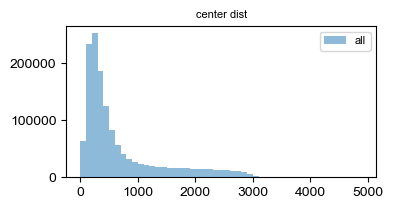

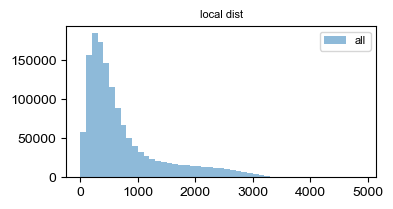

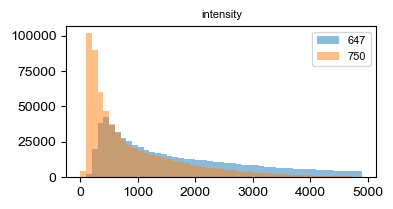

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 80.816s
-- region kept: 0.7731


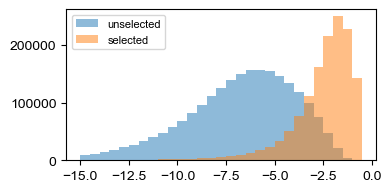

+ iter:1
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.728s
--- collapse all regions into 1d.


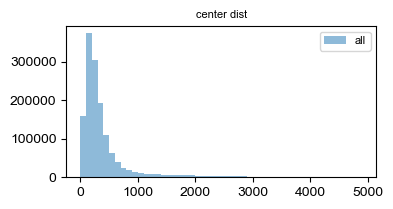

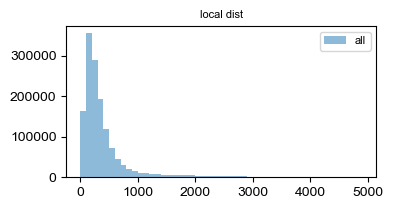

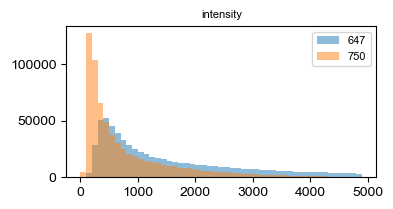

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 80.962s
-- region kept: 0.9474


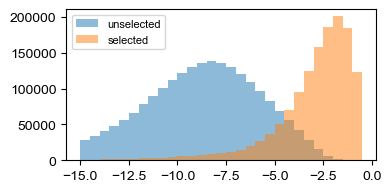

+ iter:2
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.395s
--- collapse all regions into 1d.


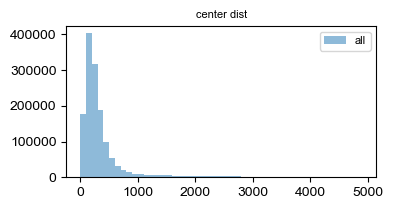

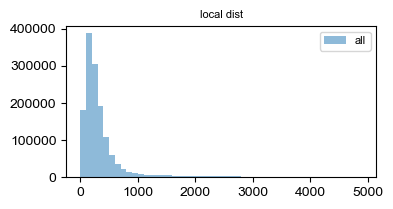

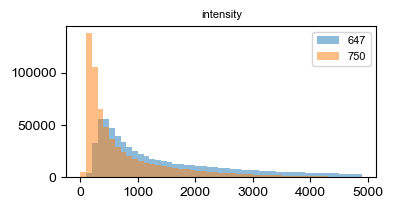

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 80.486s
-- region kept: 0.9851


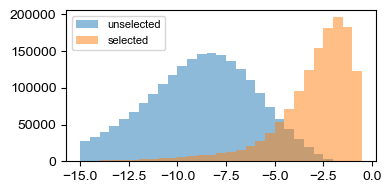

+ iter:3
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.804s
--- collapse all regions into 1d.


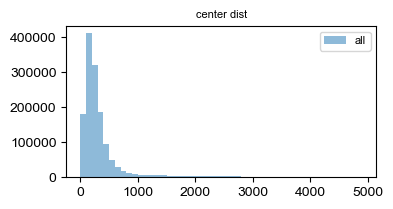

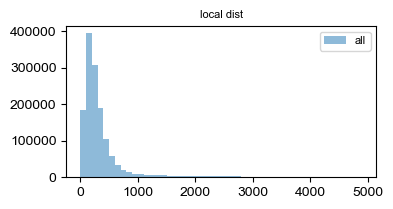

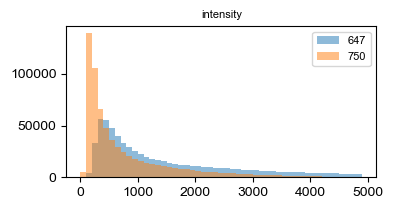

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 81.701s
-- region kept: 0.9938


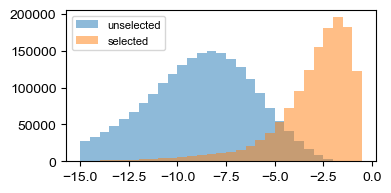

+ iter:4
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.651s
--- collapse all regions into 1d.


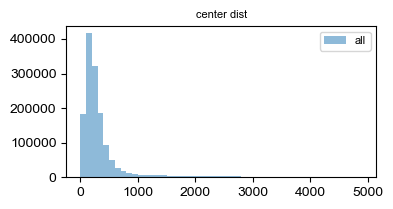

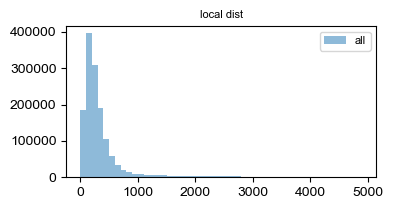

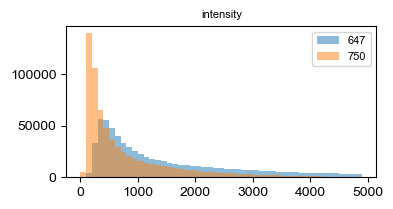

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 80.656s
-- region kept: 0.9966


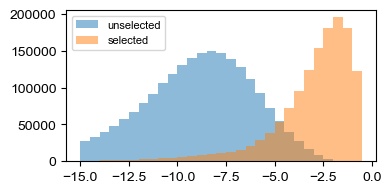

+ iter:5
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.576s
--- collapse all regions into 1d.


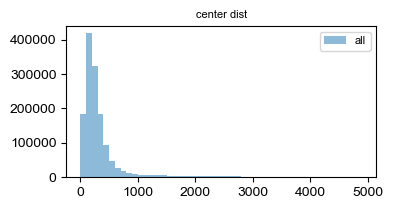

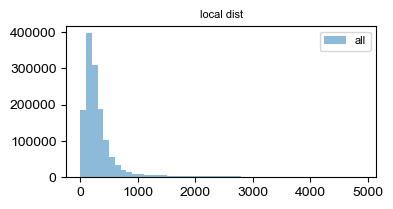

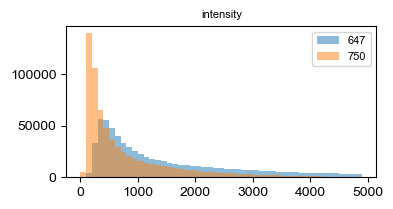

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 80.673s
-- region kept: 0.9978


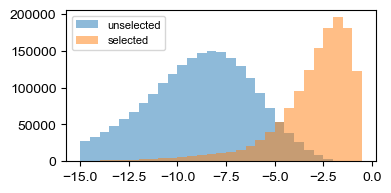

+ iter:6
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 55.419s
--- collapse all regions into 1d.


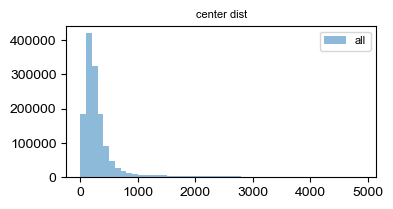

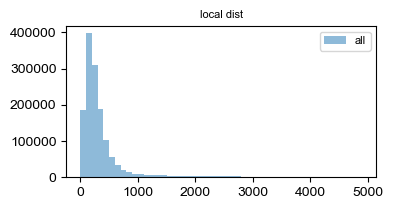

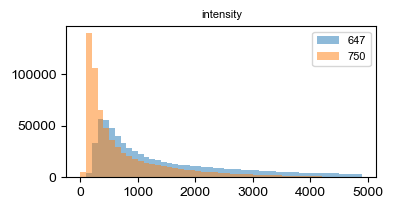

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 80.989s
-- region kept: 0.9985


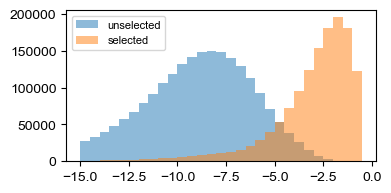

In [23]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 32
ref_chr_cts = None
# initialize
init_dna_hzxys = pick_spots_by_intensities(sel_dna_cand_hzxys_list)
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list, other_dna_scores_list = [init_dna_hzxys], [], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1], dna_reg_ids,
        ref_channels=dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    sel_hzxys_list, sel_scores_list, all_scores_list, other_scores_list = \
    pick_spots_by_scores(
        sel_dna_cand_hzxys_list, dna_reg_ids,
        cand_channels=dna_reg_channels, 
        ref_hzxys_list=sel_dna_hzxys_list[-1], ref_ids=dna_reg_ids, ref_channels=dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(sel_hzxys_list, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_dna_hzxys_list.append(sel_hzxys_list)
    sel_dna_scores_list.append(sel_scores_list)
    all_dna_scores_list.append(all_scores_list)
    other_dna_scores_list.append(other_scores_list)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in other_scores_list]), 
             bins=np.arange(-15, 0, 0.5), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_sel_scores) 
                       for _sel_scores in sel_dna_scores_list[-1]]), 
             bins=np.arange(-15, 0, 0.5), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

In [24]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = -5
int_th = 200
bad_spot_percentage = 1

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    # remove spots by intensity
    _bad_inds = _kept_hzxys[:,0] < int_th
    # remove spots by scores
    _bad_inds += _scores < score_th
    #print(np.mean(_bad_inds))
    _kept_hzxys[_bad_inds] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
kept_chrom_coords = np.array(sel_chrom_coords)[kept_chr_ids]
kept_fov_ids = np.array(sel_cand_fov_ids)[kept_chr_ids]

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

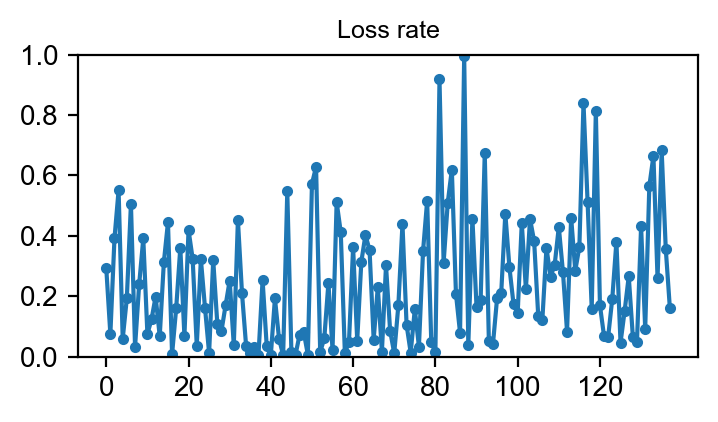

In [14]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,len(median_distmap),20))
ax.set_ylim([0,1])
ax.set_title(f"Loss rate", fontsize=9)
plt.show()

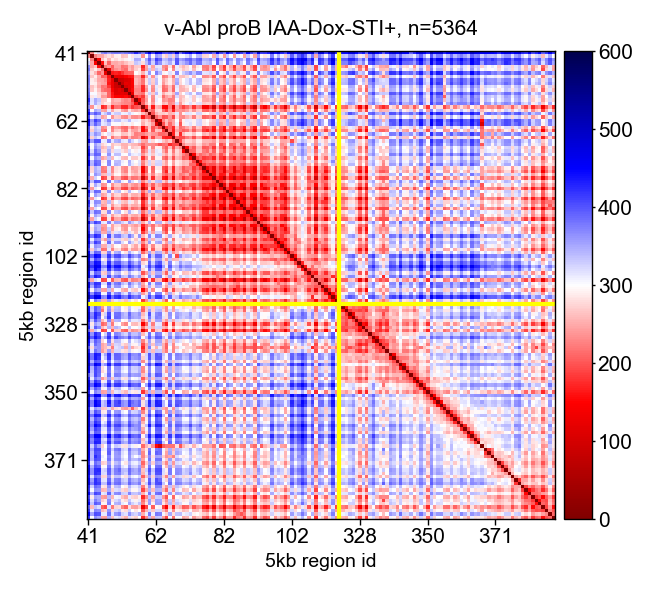

In [17]:
imaging_order = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            imaging_order.append(list(dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
#kept_inds = imaging_order # plot imaging ordered regions

#kept_inds = np.where(loss_rates<0.2)[0] # plot good regions only
#kept_inds = np.where(loss_rates>0.2)[0] # plot bad regions only
kept_inds = np.arange(len(fov.unique_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"v-Abl proB IAA-Dox-STI+, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)


ax.axvline(x=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])
ax.axhline(y=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

<ipython-input-18-5595b23df39b>:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic_r"))
  median_cmap.set_bad(color=[0.4,0.4,0.4,1])


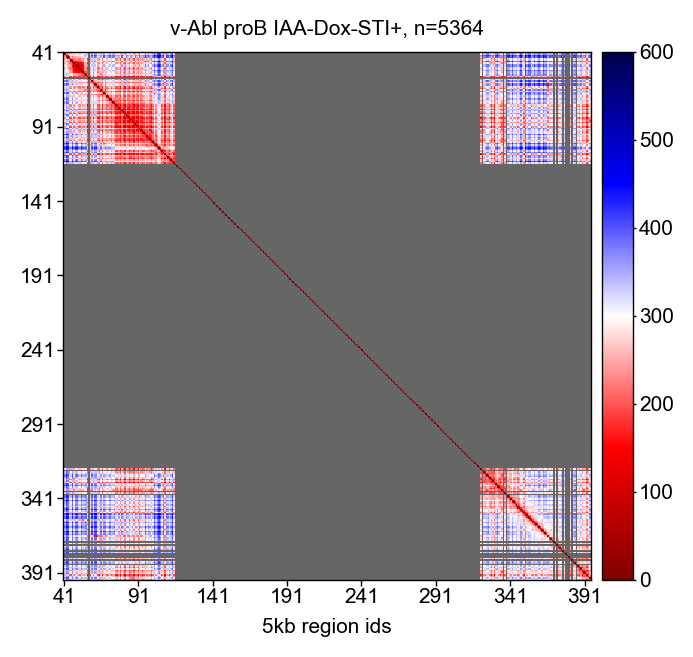

In [18]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    

import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"v-Abl proB IAA-Dox-STI+, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

## visualize single chromosome

<IPython.core.display.Javascript object>


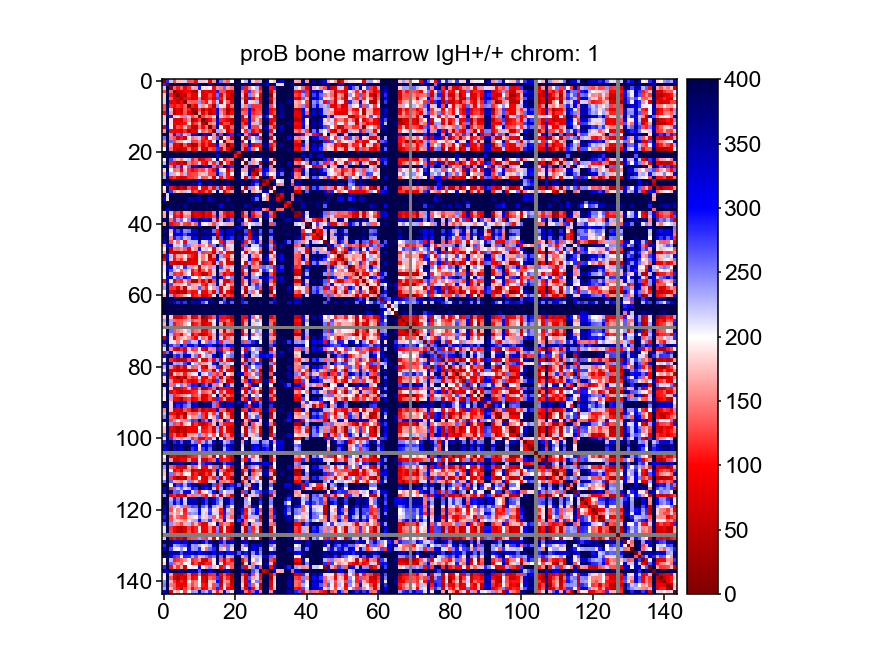

<IPython.core.display.Javascript object>


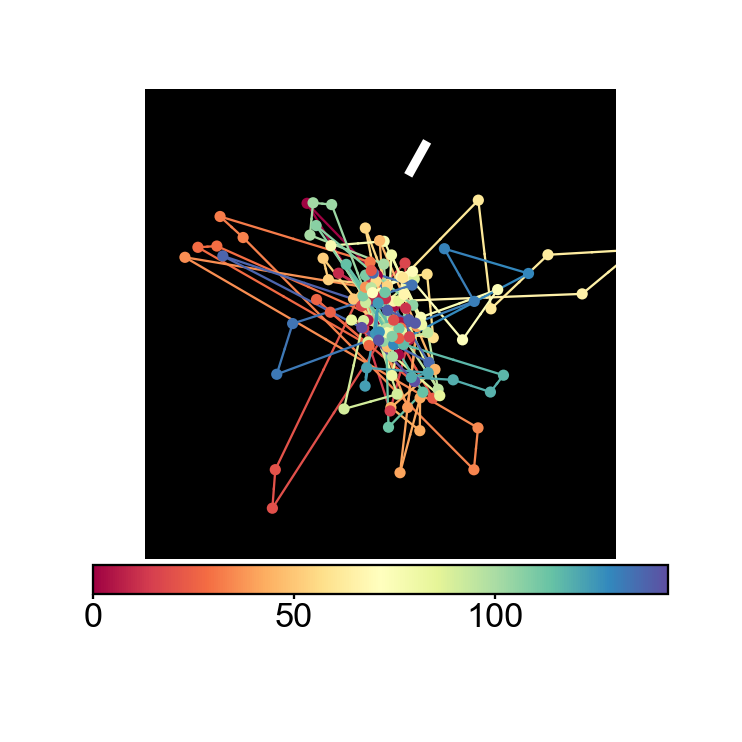

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x0000024E85557B08>


In [54]:
%matplotlib notebook

reload(figure_tools.image)

chrom_id = 1

import matplotlib
import copy

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool) # all spots

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(
        distmap_list[chrom_id][valid_inds][:,valid_inds], 
        color_limits=[0,400],
        ax=ax,
        cmap=sc_cmap,
        ticks=np.arange(0,150,20), 
        figure_dpi=200)
ax.set_title(f"proB bone marrow IgH+/+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=100, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

# Save to a temp file

In [45]:
# save picked_spots
overwrite_savefile = True

save_filename = os.path.join(fov.save_folder, f"Picked_spots_fov_{np.min(kept_fov_ids)}-{np.max(kept_fov_ids)}.pkl")

if not os.path.exists(save_filename) or overwrite_savefile:
    # assemble data dict
    picked_data = {
        'hzxys': final_dna_hzxys_list,
        'chrom_coords':kept_chrom_coords,
        'sel_scores': [_s for _s, _flag in zip(sel_dna_scores_list[-1], kept_chr_ids) if _flag],
        'other_scores': [_s for _s, _flag in zip(other_dna_scores_list[-1], kept_chr_ids) if _flag],
        'fov_ids': kept_fov_ids,
        'intensity_th': int_th,
        'score_th': score_th,
        'parameters': fov.shared_parameters,
    }
    picked_data['Notes'] = "Saved on March 16, 2021\n"

    # save
    print(f"save to file: {save_filename}")
    pickle.dump(picked_data, open(save_filename, 'wb'))

save to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20201012_bone_marrow_igh++\Picked_spots_fov_3-12.pkl


In [43]:
len(picked_data['sel_scores'])

5628

187.37310329656003


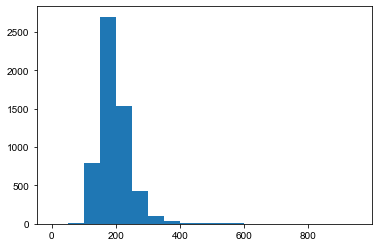

In [47]:
#radius of gyration
rgs = [spot_tools.scoring.radius_of_gyration(_hzxys[:72,1:]) for _hzxys in final_dna_hzxys_list]
print(np.median(rgs))
plt.figure()
plt.hist(rgs, bins=np.arange(0,1000,50))
plt.show()